In [1]:
import numpy as np
import pandas as pd
import re
import ast
import base64
from collections import Counter
from io import BytesIO
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, euclidean_distances
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings

pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore', category=FutureWarning)


# Data Import and Setup

In [2]:
file_path = "data/product_sku_info_with_rgb_review_v3.pkl"
df = pd.read_pickle(file_path)


In [3]:
# modify the targetUrl by replacing the skuId number
def replace_skuid(row):
    base_url = row['targetUrl']
    new_url = re.sub(r'skuId=\d+', f'skuId={row["skuID"]}', base_url)
    return new_url

df['updated_targetUrl'] = df.apply(replace_skuid, axis=1)
df['URL'] = 'https://www.sephora.com' + df['updated_targetUrl']
df = df.drop('updated_targetUrl', axis=1)

In [4]:
key_fields = [
    'reviewID', 'Rating', 'Title', 'ReviewText', 'Helpfulness', 'IsRecommended', 
    'SubmissionTime', 'ContextDataValues.skinType.ValueLabel', 
    'ContextDataValues.eyeColor.ValueLabel', 'ContextDataValues.hairColor.ValueLabel', 
    'ContextDataValues.skinTone.ValueLabel', 'ContextDataValues.age.ValueLabel', 
    'productID', 'skuID', 
    'cover_image_base64', 'lipstick_image_base64', 'avg_rgb', 'color_description', 
    'brandName', 'displayName', 'heroImage', 'altImage',
    'currentSku.imageAltText', 'rating', 'reviews', 'currentSku.listPrice', 'URL']

df_review = df[key_fields]

# Review Analysis

## Review Data Frame Preparation

### check null values

In [5]:
# Get count of non-NaN and NaN values for each column and add pct of NaN values
value_counts = pd.DataFrame({
    "Non-NaN Count": df_review.notna().sum(),
    "NaN Count": df_review.isna().sum(),
    "Total Count": len(df)
})

value_counts["NaN Percentage"] = (value_counts["NaN Count"] / value_counts["Total Count"]) * 100
value_counts


,Non-NaN Count,NaN Count,Total Count,NaN Percentage
reviewID,64826,0,64826,0.000000
Rating,64826,0,64826,0.000000
Title,47582,17244,64826,26.600438
ReviewText,64714,112,64826,0.172770
Helpfulness,29018,35808,64826,55.237096
IsRecommended,64826,0,64826,0.000000
SubmissionTime,64826,0,64826,0.000000
ContextDataValues.skinType.ValueLabel,63127,1699,64826,2.620862
ContextDataValues.eyeColor.ValueLabel,62289,2537,64826,3.913553
ContextDataValues.hairColor.ValueLabel,52613,12213,64826,18.839663


### drop records with no skinTone, and skinTone = notSure and avg_rgb = [0,0,0]

In [6]:
# Drop rows where 'ContextDataValues.skinTone.ValueLabel' is missing and skinTone = notSure
df_review = df_review.dropna(subset=['ContextDataValues.skinTone.ValueLabel'])
df_review = df_review[df_review['ContextDataValues.skinTone.ValueLabel'] != 'notSure']

# Drop rows where 'avg_rgb' is [0, 0, 0] (failed rgb extraction due to image quality. total 11 SKU/ 18k review )
df_review = df_review[~df_review['avg_rgb'].apply(lambda x: np.array_equal(x, [0, 0, 0]))]
df_review = df_review.dropna(subset=['avg_rgb'])


### reclassify skin tone

In [7]:
# assign skin tone = Ebony to Rich, Olive to Tan
df_review['ContextDataValues.skinTone.ValueLabel'] = df_review['ContextDataValues.skinTone.ValueLabel'].replace({
    'Ebony':'Rich',
     'Olive':'Tan'
})

print(df_review['ContextDataValues.skinTone.ValueLabel'].unique())


['Light' 'Porcelain' 'Medium' 'Fair' 'Tan' 'Dark' 'Deep' 'lightMedium'
 'mediumTan' 'Rich' 'fairLight']


In [8]:
print(f"# Total Reviews: {df_review.shape[0]}")
print(f"# Total SKUs: {df_review['skuID'].nunique()}")
print(f"# Products: {df_review['productID'].nunique()}")

# Total Reviews: 53539
# Total SKUs: 1108
# Products: 215


## Review Distribution (SKU, Rating, User Context)

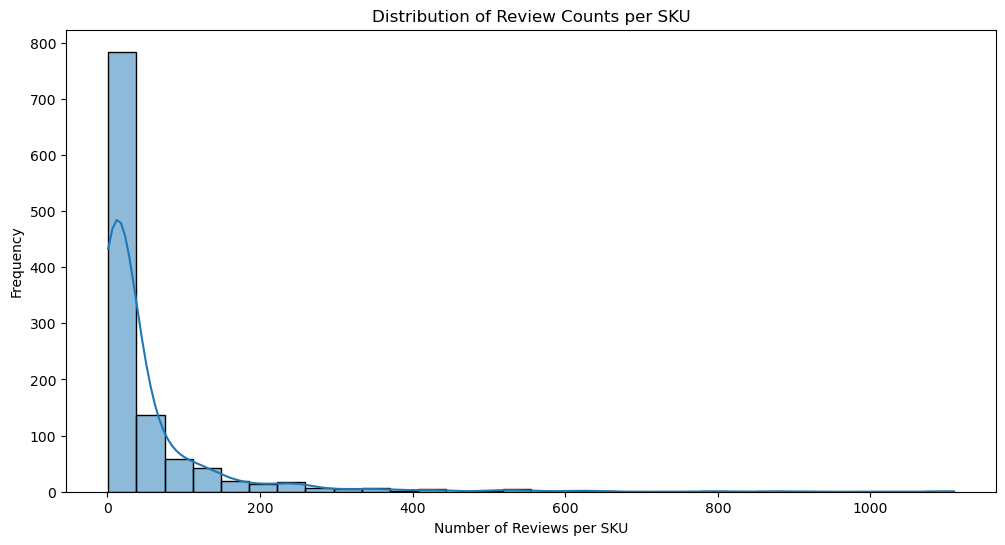

In [9]:
#Distribution of Review Counts per SKU
reviews_per_sku = df_review['skuID'].value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_sku, bins=30, kde=True)
plt.title("Distribution of Review Counts per SKU")
plt.xlabel("Number of Reviews per SKU")
plt.ylabel("Frequency")
plt.show()


## Product, SKU, and Review Distribution by Skin Tone

In [10]:
# Product, SKU, and review count per skin tone, sorted by SKU count
SkinToneDescription = df_review.groupby(['ContextDataValues.skinTone.ValueLabel']).agg(
    Product_Count=('productID', 'nunique'),   
    SKU_Count=('skuID', 'nunique'),          
    Review_Count=('reviewID', 'nunique')     
).reset_index().sort_values(by='SKU_Count', ascending=False)

SkinToneDescription


,ContextDataValues.skinTone.ValueLabel,Product_Count,SKU_Count,Review_Count
3,Light,209,965,15722
2,Fair,210,910,11527
4,Medium,194,789,6341
9,lightMedium,199,784,6312
7,Tan,183,641,3386
8,fairLight,181,526,2151
10,mediumTan,170,476,1862
1,Deep,162,473,1792
5,Porcelain,109,242,883
6,Rich,77,139,271


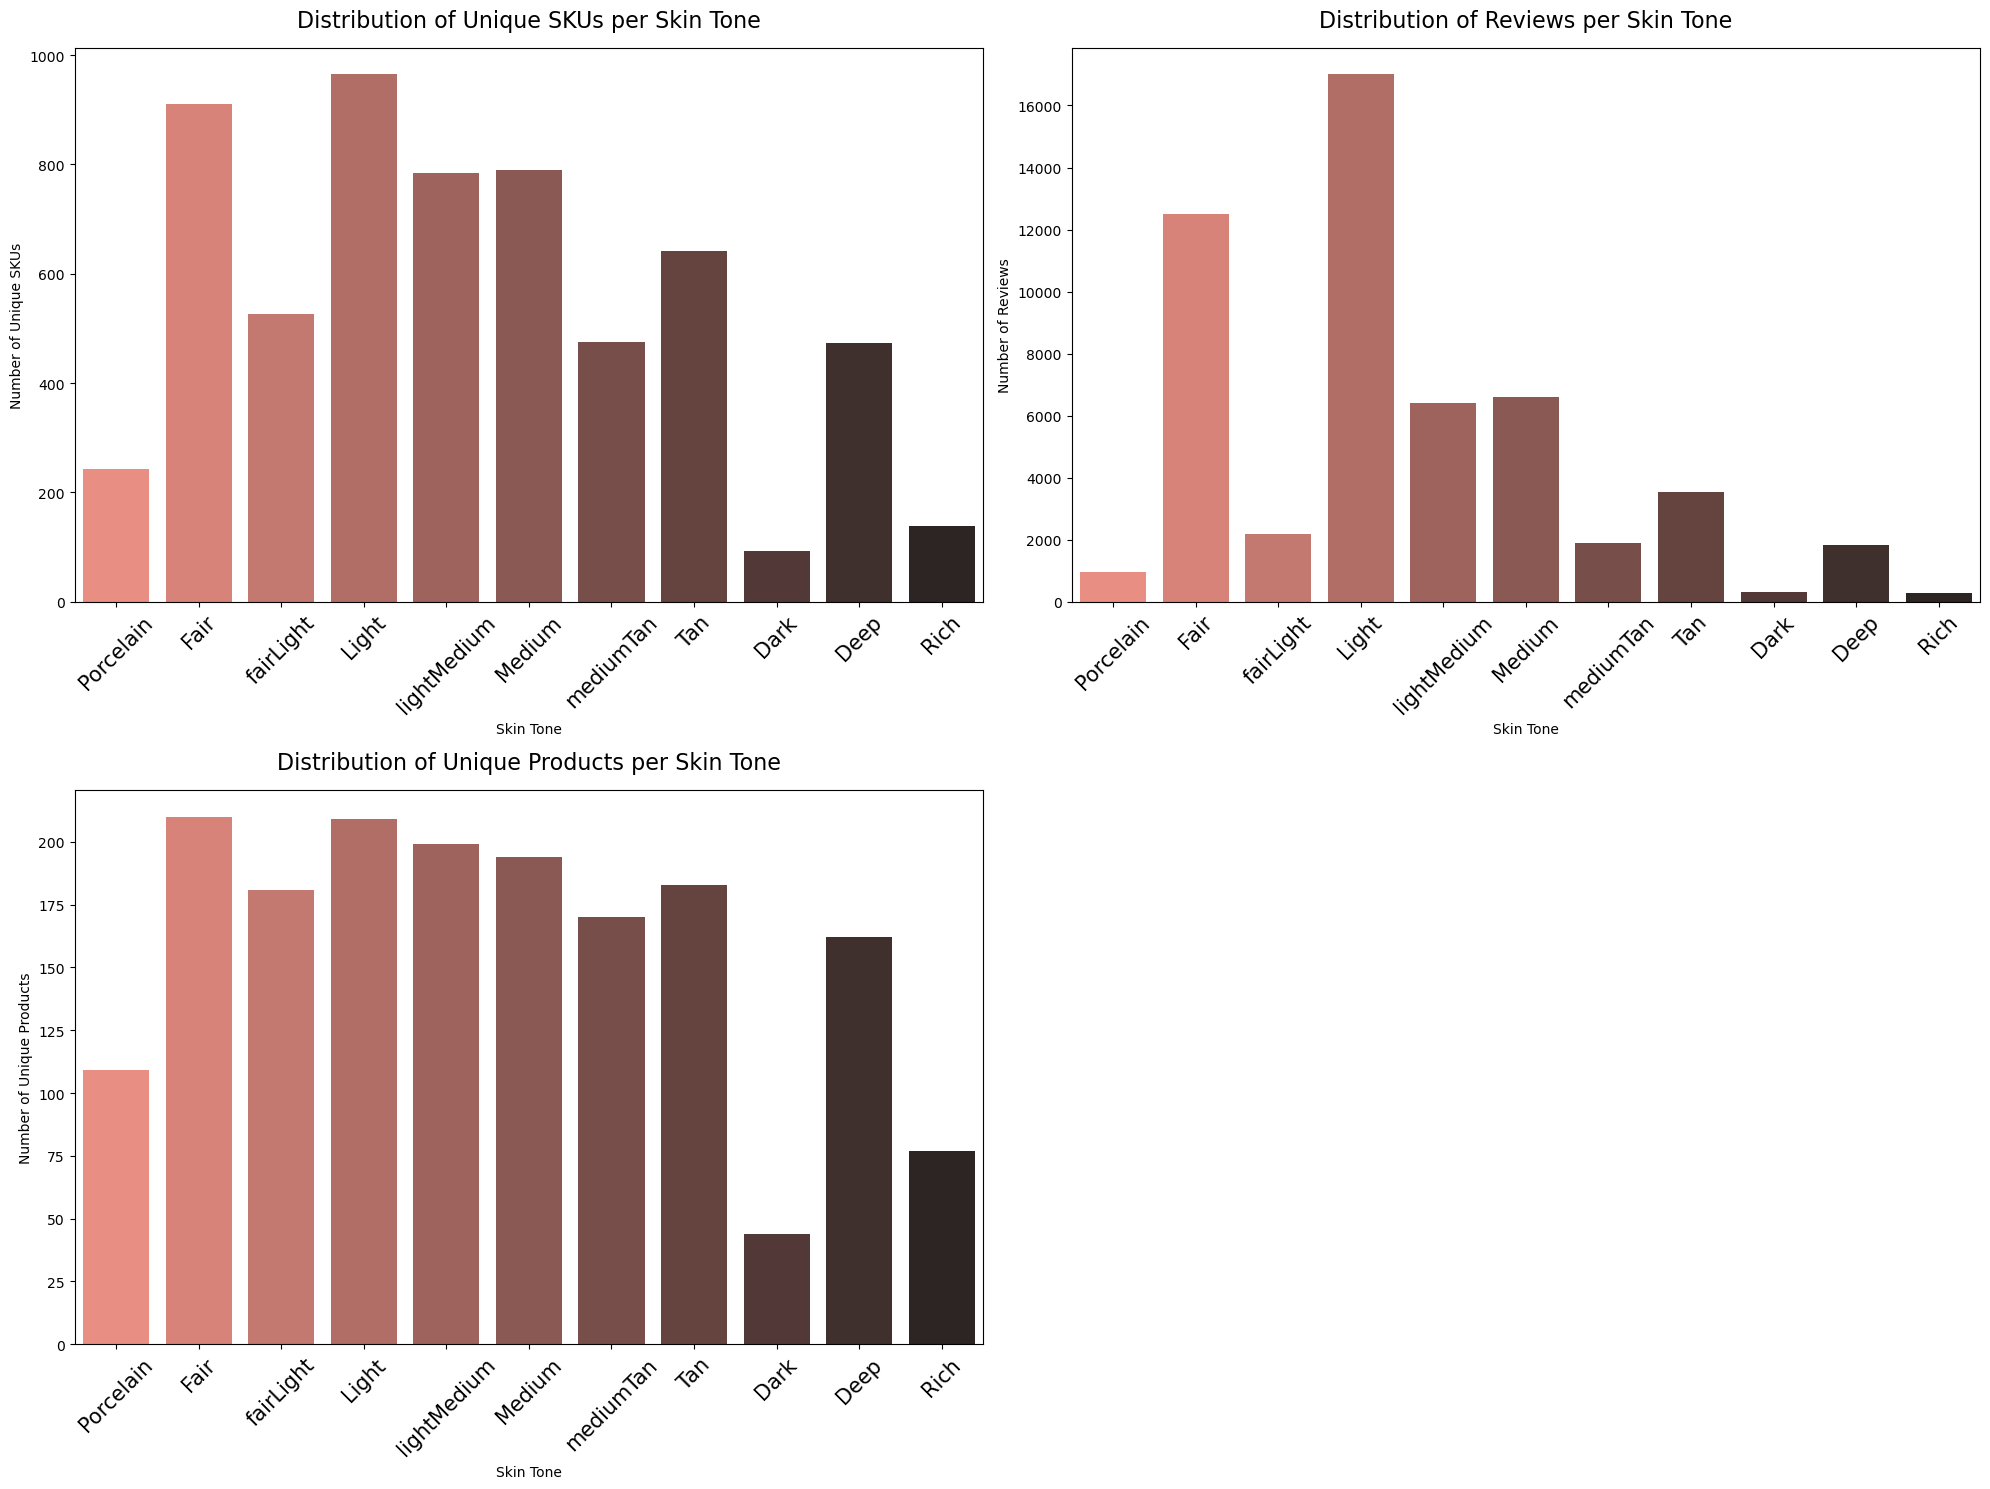

In [11]:
# We would like to display skin tone from lightest to darkest
skin_tone_order = [
    "Porcelain", "Fair", "fairLight", "Light", "lightMedium", 
    "Medium", "mediumTan", "Tan", "Dark", "Deep", "Rich"
]

# Calculate the number of unique products per skin tone, the number of unique SKUs per skin tone, the number of reviews per skin tone,
product_per_skin_tone = (
    df_review.groupby('ContextDataValues.skinTone.ValueLabel')['productID']
    .nunique()
    .reset_index(name='UniqueProductCount')
)

sku_per_skin_tone = (
    df_review.groupby('ContextDataValues.skinTone.ValueLabel')['skuID']
    .nunique()
    .reset_index(name='UniqueSKUCount')
)

reviews_per_skin_tone = (
    df_review['ContextDataValues.skinTone.ValueLabel']
    .value_counts()
    .reindex(skin_tone_order)  
    .reset_index()
)
reviews_per_skin_tone.columns = ['SkinTone', 'ReviewCount']

product_per_skin_tone['ContextDataValues.skinTone.ValueLabel'] = pd.Categorical(
    product_per_skin_tone['ContextDataValues.skinTone.ValueLabel'], 
    categories=skin_tone_order, 
    ordered=True
)
product_per_skin_tone = product_per_skin_tone.sort_values('ContextDataValues.skinTone.ValueLabel')

sku_per_skin_tone['ContextDataValues.skinTone.ValueLabel'] = pd.Categorical(
    sku_per_skin_tone['ContextDataValues.skinTone.ValueLabel'], 
    categories=skin_tone_order, 
    ordered=True
)
sku_per_skin_tone = sku_per_skin_tone.sort_values('ContextDataValues.skinTone.ValueLabel')

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()


# Unique Product count per skin tone
sns.barplot(
    data=product_per_skin_tone, 
    x='ContextDataValues.skinTone.ValueLabel', 
    y='UniqueProductCount', 
    palette='dark:salmon_r', 
    ax=axes[2]
)
axes[2].set_title("Distribution of Unique Products per Skin Tone",fontsize=16, pad = 15)
axes[2].set_xlabel("Skin Tone")
axes[2].set_ylabel("Number of Unique Products")
axes[2].tick_params(axis='x', rotation=45,  labelsize=15)

# Unique SKU count per skin tone
sns.barplot(
    data=sku_per_skin_tone, 
    x='ContextDataValues.skinTone.ValueLabel', 
    y='UniqueSKUCount', 
    palette='dark:salmon_r', 
    ax=axes[0]
)
axes[0].set_title("Distribution of Unique SKUs per Skin Tone",fontsize=16, pad = 15)
axes[0].set_xlabel("Skin Tone")
axes[0].set_ylabel("Number of Unique SKUs")
axes[0].tick_params(axis='x', rotation=45,  labelsize=15)

# Review count per skin tone
sns.barplot(
    data=reviews_per_skin_tone, 
    x='SkinTone', 
    y='ReviewCount', 
    palette='dark:salmon_r', 
    ax=axes[1]
)
axes[1].set_title("Distribution of Reviews per Skin Tone",fontsize=16, pad = 15)
axes[1].set_xlabel("Skin Tone")
axes[1].set_ylabel("Number of Reviews")
axes[1].tick_params(axis='x', rotation=45,  labelsize=15)

axes[3].axis('off')

plt.tight_layout()
plt.show()


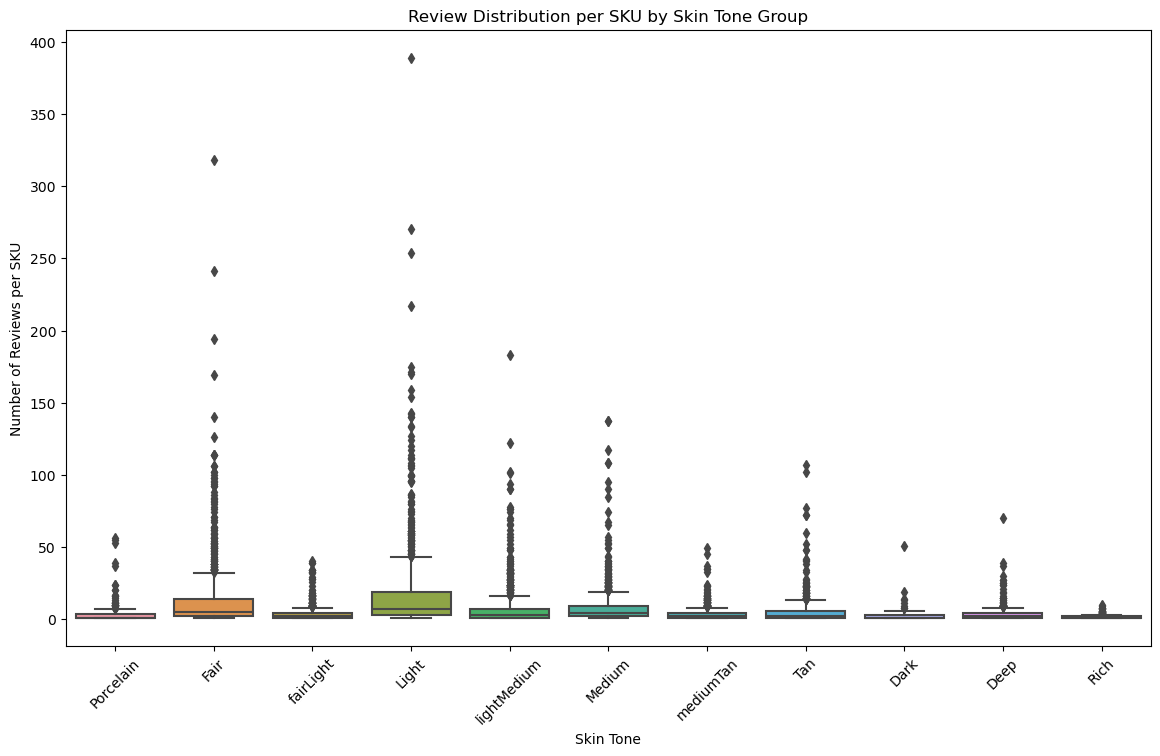

In [12]:
# Review Distribution per SKU by Skin Tone Group
reviews_per_sku_by_skin_tone = (
    df_review.groupby(['ContextDataValues.skinTone.ValueLabel', 'skuID'])
    .size()
    .reset_index(name='ReviewCount')
)

reviews_per_sku_by_skin_tone['ContextDataValues.skinTone.ValueLabel'] = pd.Categorical(
    reviews_per_sku_by_skin_tone['ContextDataValues.skinTone.ValueLabel'], 
    categories=skin_tone_order, 
    ordered=True
)

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=reviews_per_sku_by_skin_tone, 
    x='ContextDataValues.skinTone.ValueLabel', 
    y='ReviewCount'
)
plt.title("Review Distribution per SKU by Skin Tone Group")
plt.xlabel("Skin Tone")
plt.ylabel("Number of Reviews per SKU")
plt.xticks(rotation=45)
plt.show()


# SKU Analysis
SKU color cluster analysis: this process assists in identifying issues with image matching and RGB extraction, as well as understanding the distribution of color shades

## SKU Data Frame

In [13]:
sku_feature = ['productID', 'rating','reviews','skuID','currentSku.imageAltText','currentSku.listPrice',
       'cover_image_base64', 'lipstick_image_base64', 'avg_rgb',
       'color_description', 'brandName', 'displayName', 'heroImage',
       'altImage','URL', 'reviewID','Rating']

In [14]:
# Aggregate the review dataframe to SKU level by calculating the average rating and total reviews per skuID
df_sku = df_review.groupby('skuID').agg(
    productID=('productID', 'first'),                              
    productRating=('rating', 'first'),                             
    productReviews=('reviews', 'first'),                           
    currentSku_imageAltText=('currentSku.imageAltText', 'first'),  
    currentSku_listPrice=('currentSku.listPrice', 'first'),        
    cover_image_base64=('cover_image_base64', 'first'),            
    lipstick_image_base64=('lipstick_image_base64', 'first'),      
    avg_rgb=('avg_rgb', 'first'),                                  
    color_description=('color_description', 'first'),              
    brandName=('brandName', 'first'),                              
    displayName=('displayName', 'first'),                        
    heroImage=('heroImage', 'first'),                              
    altImage=('altImage', 'first'),                                
    URL=('URL', 'first'), 
    skuRating=('Rating', 'mean'),                                  
    skuTotalReviews=('reviewID', 'count')                          
).reset_index()



In [15]:
print(f"Unqiue SKU: {df_sku.shape[0]}, Unique products: {df_sku['productID'].nunique()}")

Unqiue SKU: 1108, Unique products: 215


## SKU Color Cluster Analysis

In [16]:
# create R, G, B columns based on avg_rgb column and normalize the RGB Values
df_sku[['R', 'G', 'B']] = pd.DataFrame(df_sku['avg_rgb'].tolist(), index=df_sku.index)
df_sku[['R', 'G', 'B']] = df_sku[['R', 'G', 'B']] / 255.0  


In [17]:
df_sku.head(2)

,skuID,productID,productRating,productReviews,currentSku_imageAltText,currentSku_listPrice,cover_image_base64,lipstick_image_base64,avg_rgb,color_description,brandName,displayName,heroImage,altImage,URL,skuRating,skuTotalReviews,R,G,B
0,1005438,P183919,4.4399,2121,MAKE UP FOR EVER - Aqua Lip Waterproof Lipline...,$22.00,,/9j/4AAQSkZJRgABAgAAZABkAAD/7AARRHVja3kAAQAEAA...,"[195, 131, 136]",Out of stock: 2C Rosewood,MAKE UP FOR EVER,Aqua Lip Waterproof Lipliner Pencil,https://www.sephora.com/productimages/sku/s105...,None,https://www.sephora.com/product/aqua-lip-water...,4.285714,49,0.764706,0.513725,0.533333
1,1005446,P183919,4.4399,2121,MAKE UP FOR EVER - Aqua Lip Waterproof Lipline...,$22.00,,/9j/4AAQSkZJRgABAgAAZABkAAD/7AARRHVja3kAAQAEAA...,"[190, 133, 126]",Out of stock: 3C Medium Natural Beige,MAKE UP FOR EVER,Aqua Lip Waterproof Lipliner Pencil,https://www.sephora.com/productimages/sku/s105...,None,https://www.sephora.com/product/aqua-lip-water...,4.649123,57,0.745098,0.521569,0.494118


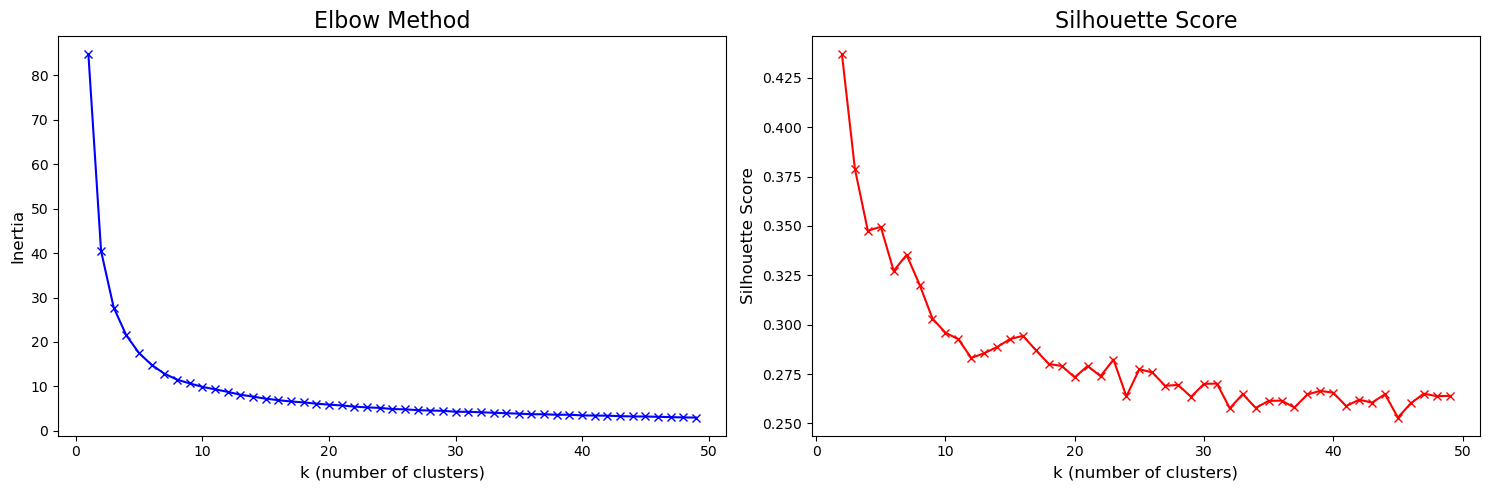

In [18]:
# Use eblow method and silhouette score to find best number of clusters
X = df_sku[['R', 'G', 'B']].values
def calculate_inertia(X, k_range):
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        if k > 1:  
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        else:
            silhouette_scores.append(0)
            
    return inertias, silhouette_scores

k_range = range(1, 50)
inertias, silhouette_scores = calculate_inertia(X, k_range)

# Create subplot for both methods: elbow method and sihouette score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(k_range, inertias, 'bx-')
ax1.set_xlabel('k (number of clusters)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method', fontsize=16)


ax2.plot(k_range[1:], silhouette_scores[1:], 'rx-')
ax2.set_xlabel('k (number of clusters)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score', fontsize=16)

plt.tight_layout()
plt.show()

In [19]:
df_max = df_sku.groupby('productID')['skuID'].nunique().sort_values().reset_index().iloc[-1,:]

print(f"The product {df_max['productID']} has the most color shades of {df_max['skuID']}")

The product P421813 has the most color shades of 26


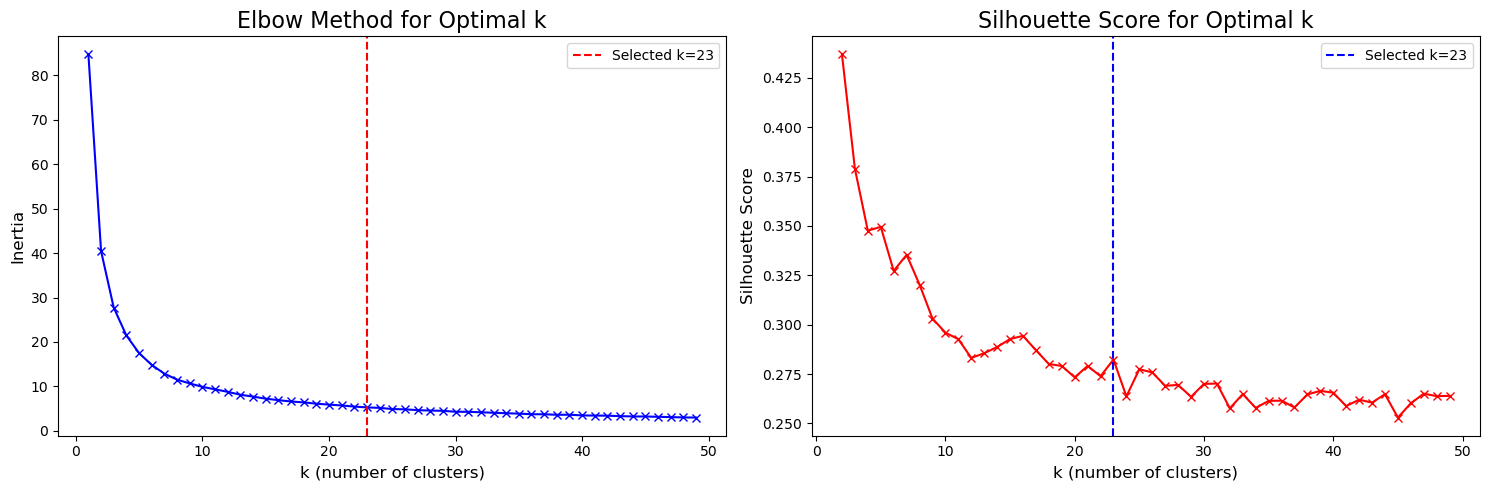

In [20]:
# Sephora websites list 14 color shades. Of all products,PAT McGRATH LABS has the most color shades of 26. 
# Combing with the elbow and silhouettte score, we decide the that the optimal k is 23
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(k_range, inertias, 'bx-')
ax1.set_xlabel('k (number of clusters)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=16)
ax1.axvline(x=23, color='r', linestyle='--', label='Selected k=23')
ax1.legend()


ax2.plot(k_range[1:], silhouette_scores[1:], 'rx-')
ax2.set_xlabel('k (number of clusters)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Optimal k', fontsize=16)
ax2.axvline(x=23, color='b', linestyle='--', label='Selected k=23')
ax2.legend()

plt.tight_layout()
plt.show()


Cluster Centers (RGB values):
Cluster 0: R=0.47, G=0.22, B=0.23
Cluster 1: R=0.79, G=0.58, B=0.56
Cluster 2: R=0.75, G=0.30, B=0.32
Cluster 3: R=0.89, G=0.73, B=0.70
Cluster 4: R=0.66, G=0.45, B=0.44
Cluster 5: R=0.61, G=0.28, B=0.26
Cluster 6: R=0.76, G=0.42, B=0.41
Cluster 7: R=0.89, G=0.46, B=0.58
Cluster 8: R=0.74, G=0.17, B=0.25
Cluster 9: R=0.86, G=0.50, B=0.47
Cluster 10: R=0.39, G=0.13, B=0.14
Cluster 11: R=0.74, G=0.50, B=0.50
Cluster 12: R=0.89, G=0.87, B=0.87
Cluster 13: R=0.66, G=0.36, B=0.36
Cluster 14: R=0.87, G=0.36, B=0.39
Cluster 15: R=0.39, G=0.74, B=0.74
Cluster 16: R=0.76, G=0.11, B=0.12
Cluster 17: R=0.89, G=0.61, B=0.58
Cluster 18: R=0.53, G=0.32, B=0.34
Cluster 19: R=0.60, G=0.14, B=0.15
Cluster 20: R=0.89, G=0.23, B=0.25
Cluster 21: R=0.90, G=0.67, B=0.25
Cluster 22: R=0.64, G=0.20, B=0.32

Cluster Sizes:
cluster
0     52
1     65
2     59
3     37
4     79
5     53
6     98
7     25
8     32
9     90
10    37
11    97
12    31
13    91
14    51
15     3
16    

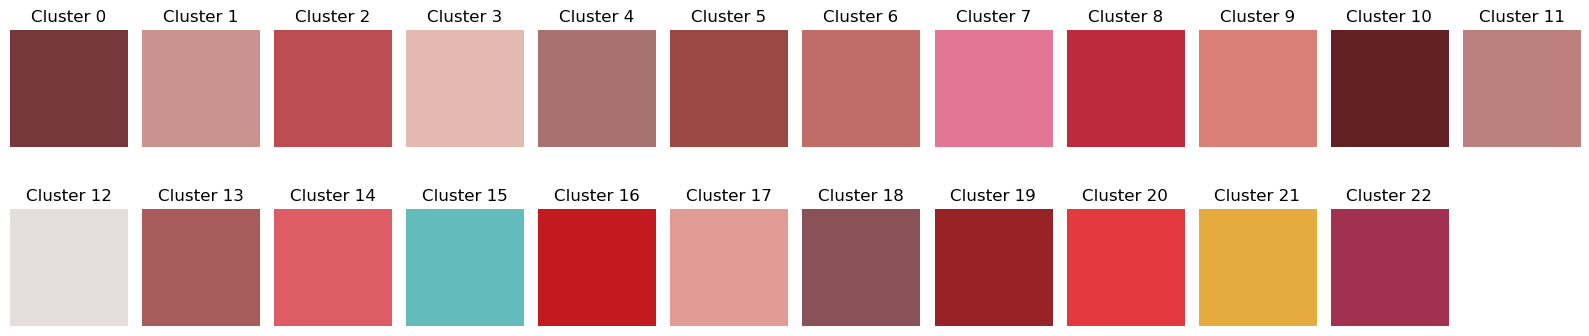

In [21]:
# Perform clustering with k=23
n_clusters = 23
final_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X)

df_sku['cluster'] = cluster_labels

cluster_centers = final_kmeans.cluster_centers_
cluster_rgb = {
    i: {
        'R': center[0],
        'G': center[1],
        'B': center[2]
    }
    for i, center in enumerate(cluster_centers)
}
df_sku['cluster_R'] = df_sku['cluster'].map(lambda x: cluster_rgb[x]['R'])
df_sku['cluster_G'] = df_sku['cluster'].map(lambda x: cluster_rgb[x]['G'])
df_sku['cluster_B'] = df_sku['cluster'].map(lambda x: cluster_rgb[x]['B'])

# Print cluster centers (average RGB values for each cluster)
cluster_centers = final_kmeans.cluster_centers_
print("\nCluster Centers (RGB values):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: R={center[0]:.2f}, G={center[1]:.2f}, B={center[2]:.2f}")

# Print cluster sizes
print("\nCluster Sizes:")
print(df_sku['cluster'].value_counts().sort_index())

plt.figure(figsize=(16, 4))
for i, center in enumerate(cluster_centers):
    plt.subplot(2, 12, i+1)
    plt.axis('off')
    plt.imshow([[center]])
    plt.title(f'Cluster {i}')
plt.tight_layout()
plt.show()

In [22]:
# Apply KMeans clustering and Assign descriptive names based on the most common color description
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_sku['ColorCluster'] = kmeans.fit_predict(df_sku[['R', 'G', 'B']])

cluster_centers = kmeans.cluster_centers_
cluster_colors = (cluster_centers * 255).astype(int)

cluster_descriptions = {}
for cluster in range(n_clusters):
    cluster_data = df_sku[df_sku['ColorCluster'] == cluster]
    
    def clean_color_name(desc):
        if pd.isna(desc):
            return None
        
        parts = str(desc).replace(':', ' ').replace('-', ' ').split()
        start_idx = 0
        while start_idx < len(parts) and (parts[start_idx].isdigit() or 
                                        (parts[start_idx] and parts[start_idx][0].isdigit())):
            start_idx += 1
            
        if start_idx < len(parts):
            return ' '.join(parts[start_idx:])
        return desc
    
    valid_descriptions = cluster_data['color_description'].apply(clean_color_name).dropna()
    most_common_description = (
        valid_descriptions.mode().iloc[0]
        if not valid_descriptions.empty else "Unknown"
    )
    
    cluster_descriptions[cluster] = most_common_description

df_sku['ClusterColorDescription'] = df_sku['ColorCluster'].map(cluster_descriptions)

# Calculate SKU count per cluster and sort clusters by SKU count
sku_count_per_cluster = df_sku.groupby('ColorCluster')['skuID'].nunique().sort_values(ascending=False)
sorted_clusters = sku_count_per_cluster.index.tolist()

In [23]:
# sorted clusters with SKU count and descriptions
sorted_cluster_info = pd.DataFrame({
    'Cluster': sorted_clusters,
    'Color_Name': [cluster_descriptions[cluster] for cluster in sorted_clusters],
    'SKU_Count': sku_count_per_cluster[sorted_clusters].values,
    'RGB_Values': [f"R:{cluster_colors[c][0]} G:{cluster_colors[c][1]} B:{cluster_colors[c][2]}" 
                  for c in sorted_clusters],
    'Unique_Descriptions': [df_sku[df_sku['ColorCluster'] == c]['color_description'].nunique() 
                          for c in sorted_clusters]
})

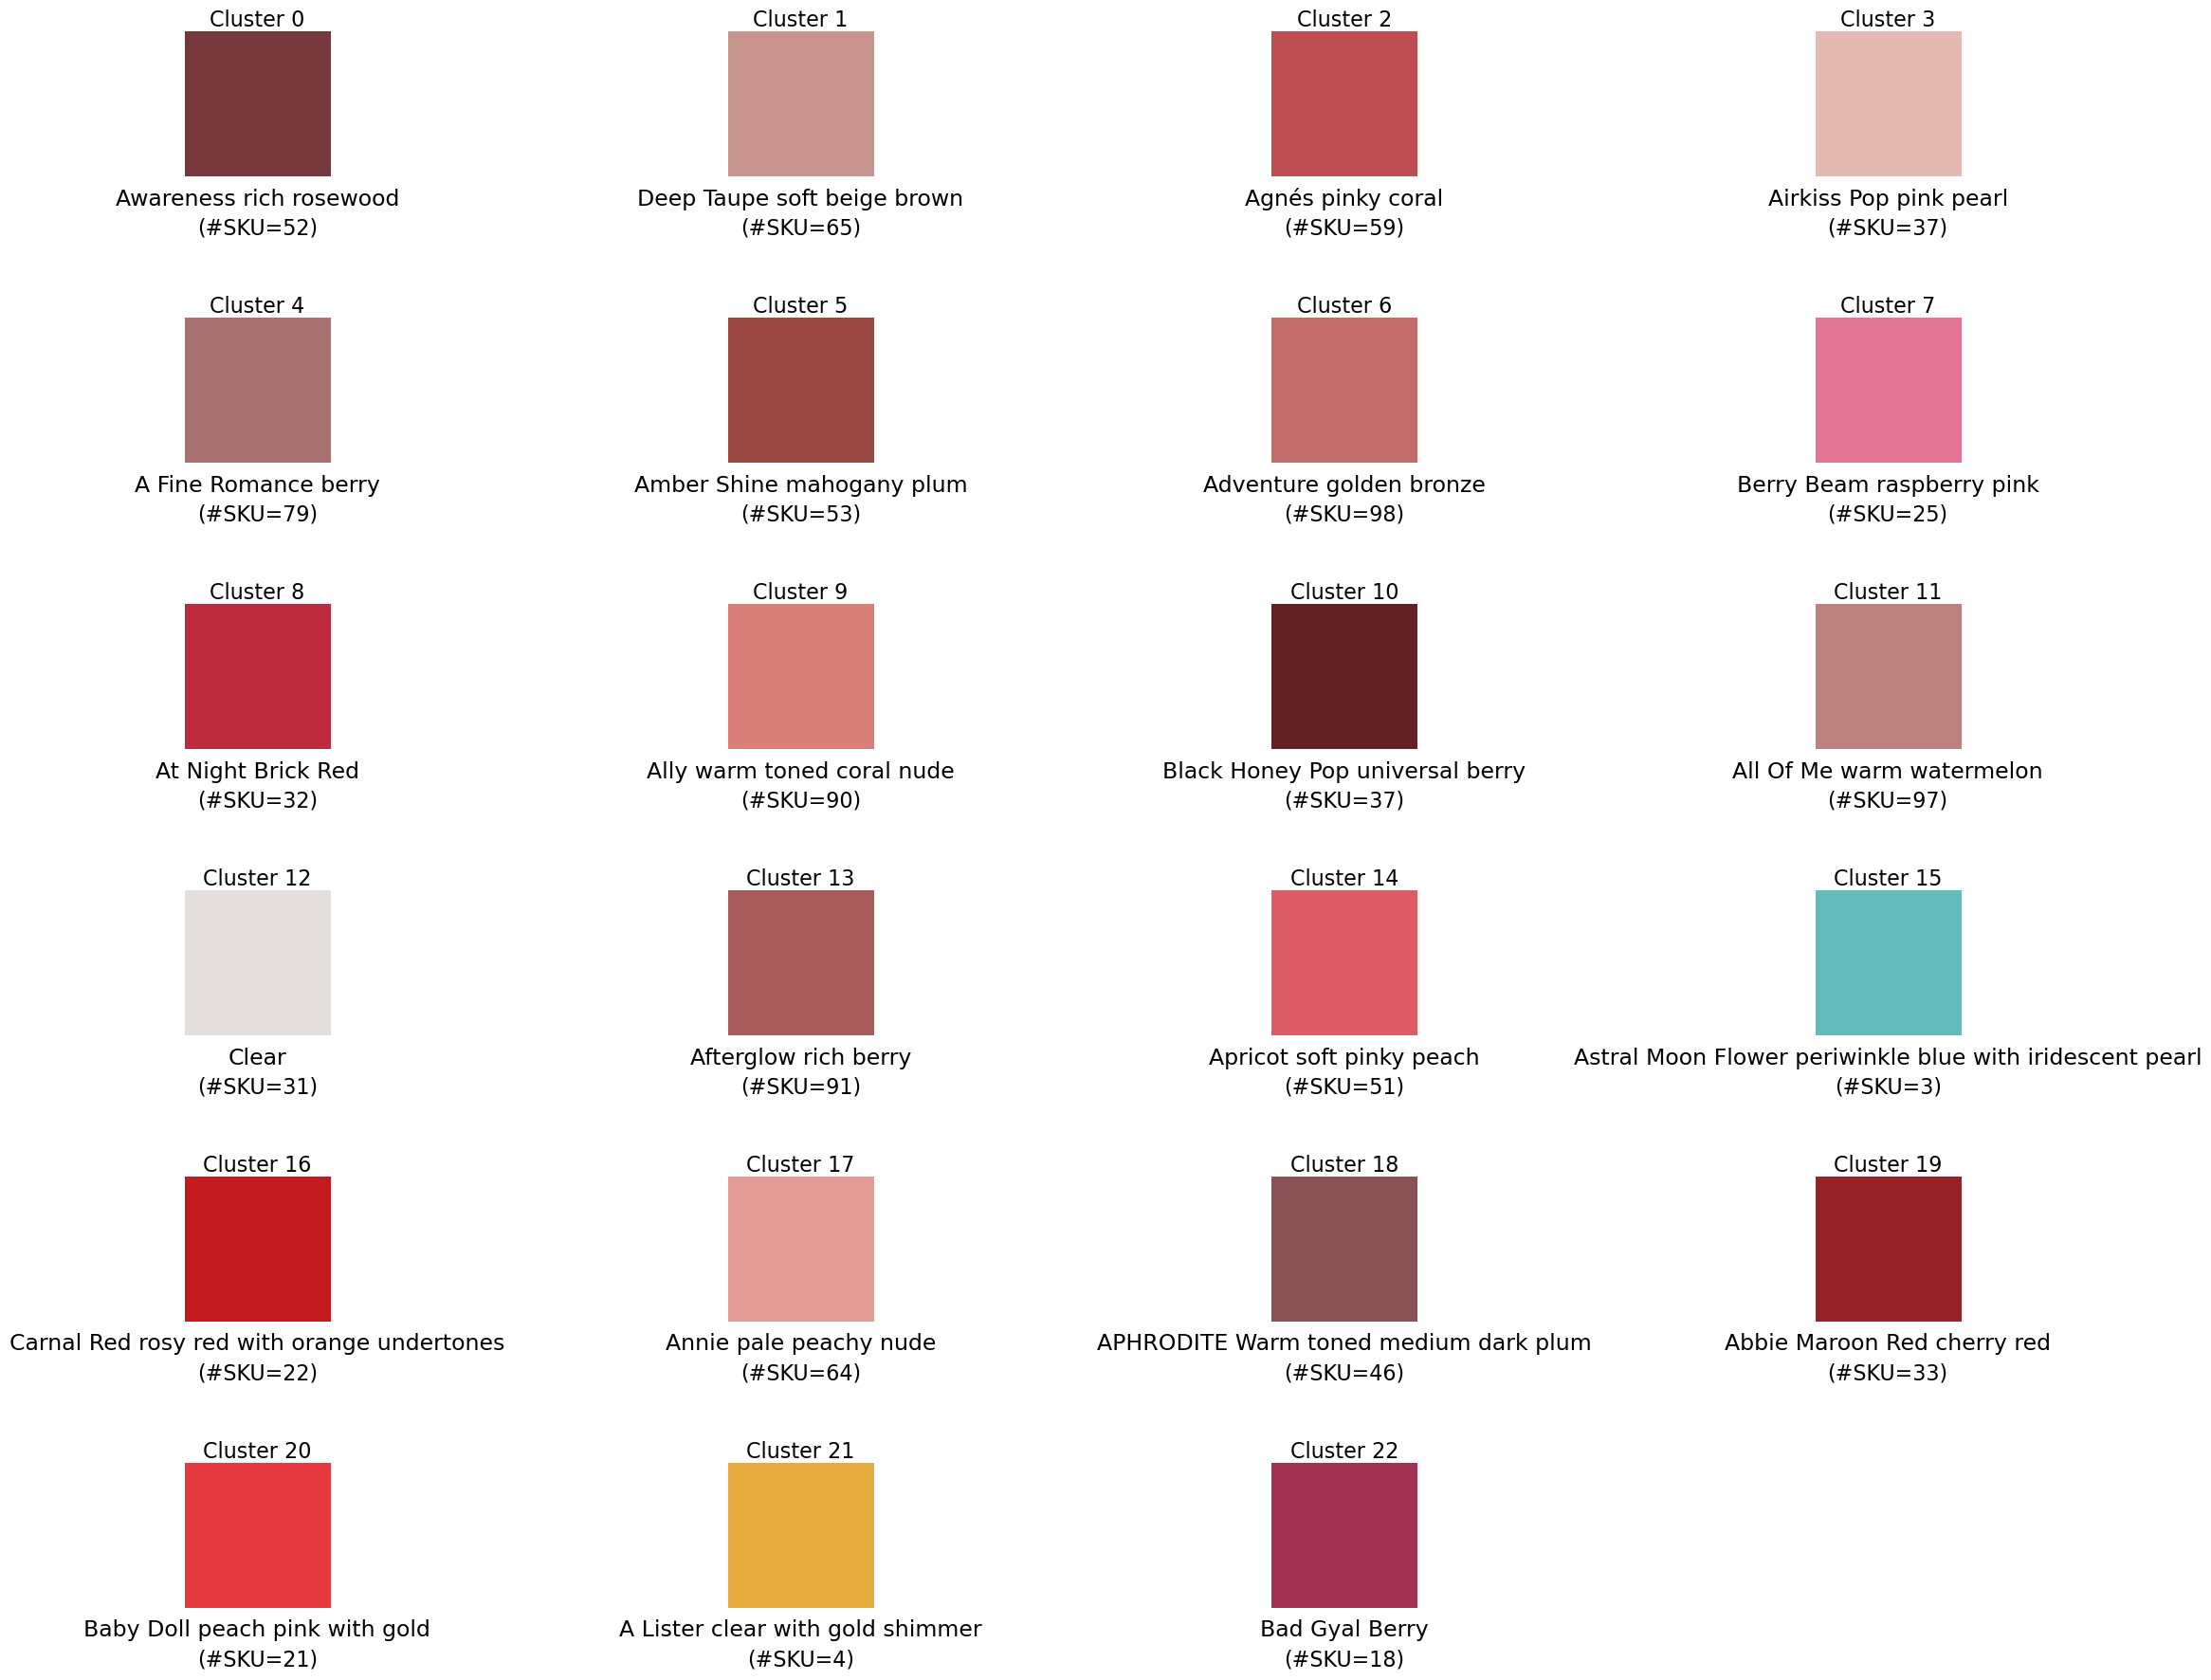

In [24]:
# Visualize clusters
plt.figure(figsize=(24, 18))
for i in range(n_clusters):
    plt.subplot(6, 4, i+1)
    plt.axis('off')
    rgb_color = cluster_colors[i] / 255.0
    plt.imshow([[rgb_color]])

    cluster_data = sorted_cluster_info[sorted_cluster_info['Cluster'] == i].iloc[0]
    color_name = cluster_data['Color_Name']
    sku_count = cluster_data['SKU_Count']
    
    # Split the title into multiple lines and set each with fontsize=15
    plt.title(f"Cluster {i}", fontsize=16, pad=3)
    plt.text(0.5, -0.2, f"{color_name}", 
             horizontalalignment='center', 
             transform=plt.gca().transAxes, 
             fontsize=17)
    plt.text(0.5, -0.4, f"(#SKU={sku_count})", 
             horizontalalignment='center', 
             transform=plt.gca().transAxes, 
             fontsize=16)

plt.tight_layout(h_pad=3, w_pad=3)  
plt.show()

In [25]:
df_sku_cluster_info = df_sku[['skuID', 'ColorCluster', 'ClusterColorDescription']]
df_review = df_review.merge(df_sku_cluster_info, on='skuID', how='left')

In [26]:
# Convert RGB values to hex for visualization
color_map = {
    cluster: {
        "color": f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}', 
        "name": cluster_descriptions[cluster]
    }
    for cluster, (r, g, b) in enumerate(kmeans.cluster_centers_)
}


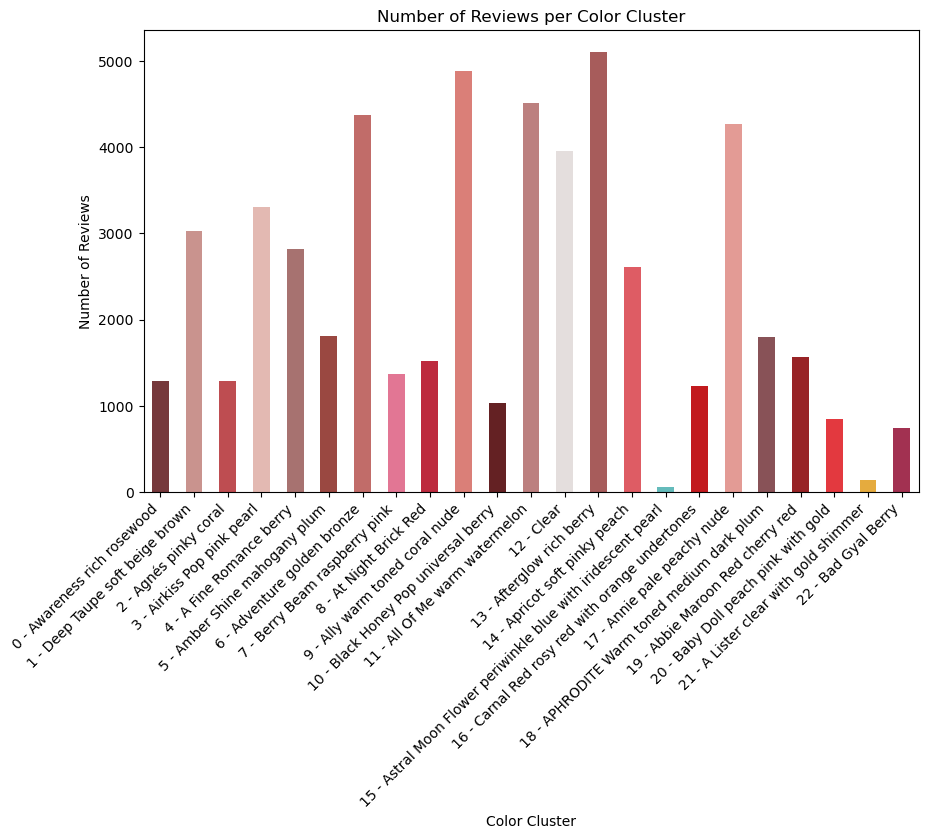

In [27]:
# Calculate the number of reviews per color cluster
reviews_per_cluster = df_review['ColorCluster'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
reviews_per_cluster.plot(
    kind='bar', 
    color=[color_map[i]["color"] for i in reviews_per_cluster.index]
)
plt.title("Number of Reviews per Color Cluster")
plt.xlabel("Color Cluster")
plt.ylabel("Number of Reviews")
plt.xticks(
    range(len(reviews_per_cluster.index)), 
    [f'{i} - {color_map[i]["name"]}' for i in reviews_per_cluster.index], 
    rotation=45, ha="right"
)
plt.show()



In [28]:
# Product, sku and review per cluster
ClusterColorDescription= df_review.groupby(['ColorCluster', 'ClusterColorDescription']).agg(
    Product_Count=('productID', 'nunique'),   # Unique count of productID per cluster
    SKU_Count=('skuID', 'nunique'),           # Unique count of skuID per cluster
    Review_Count=('reviewID', 'nunique')      # Unique count of reviewID per cluster
).reset_index().sort_values(by='Review_Count', ascending=False)

ClusterColorDescription

,ColorCluster,ClusterColorDescription,Product_Count,SKU_Count,Review_Count
13,13,Afterglow rich berry,60,91,4761
9,9,Ally warm toned coral nude,60,90,4695
11,11,All Of Me warm watermelon,58,97,4027
17,17,Annie pale peachy nude,42,64,3936
12,12,Clear,30,31,3658
6,6,Adventure golden bronze,64,98,3574
3,3,Airkiss Pop pink pearl,30,37,3265
1,1,Deep Taupe soft beige brown,44,65,2790
4,4,A Fine Romance berry,50,79,2691
14,14,Apricot soft pinky peach,41,51,2613


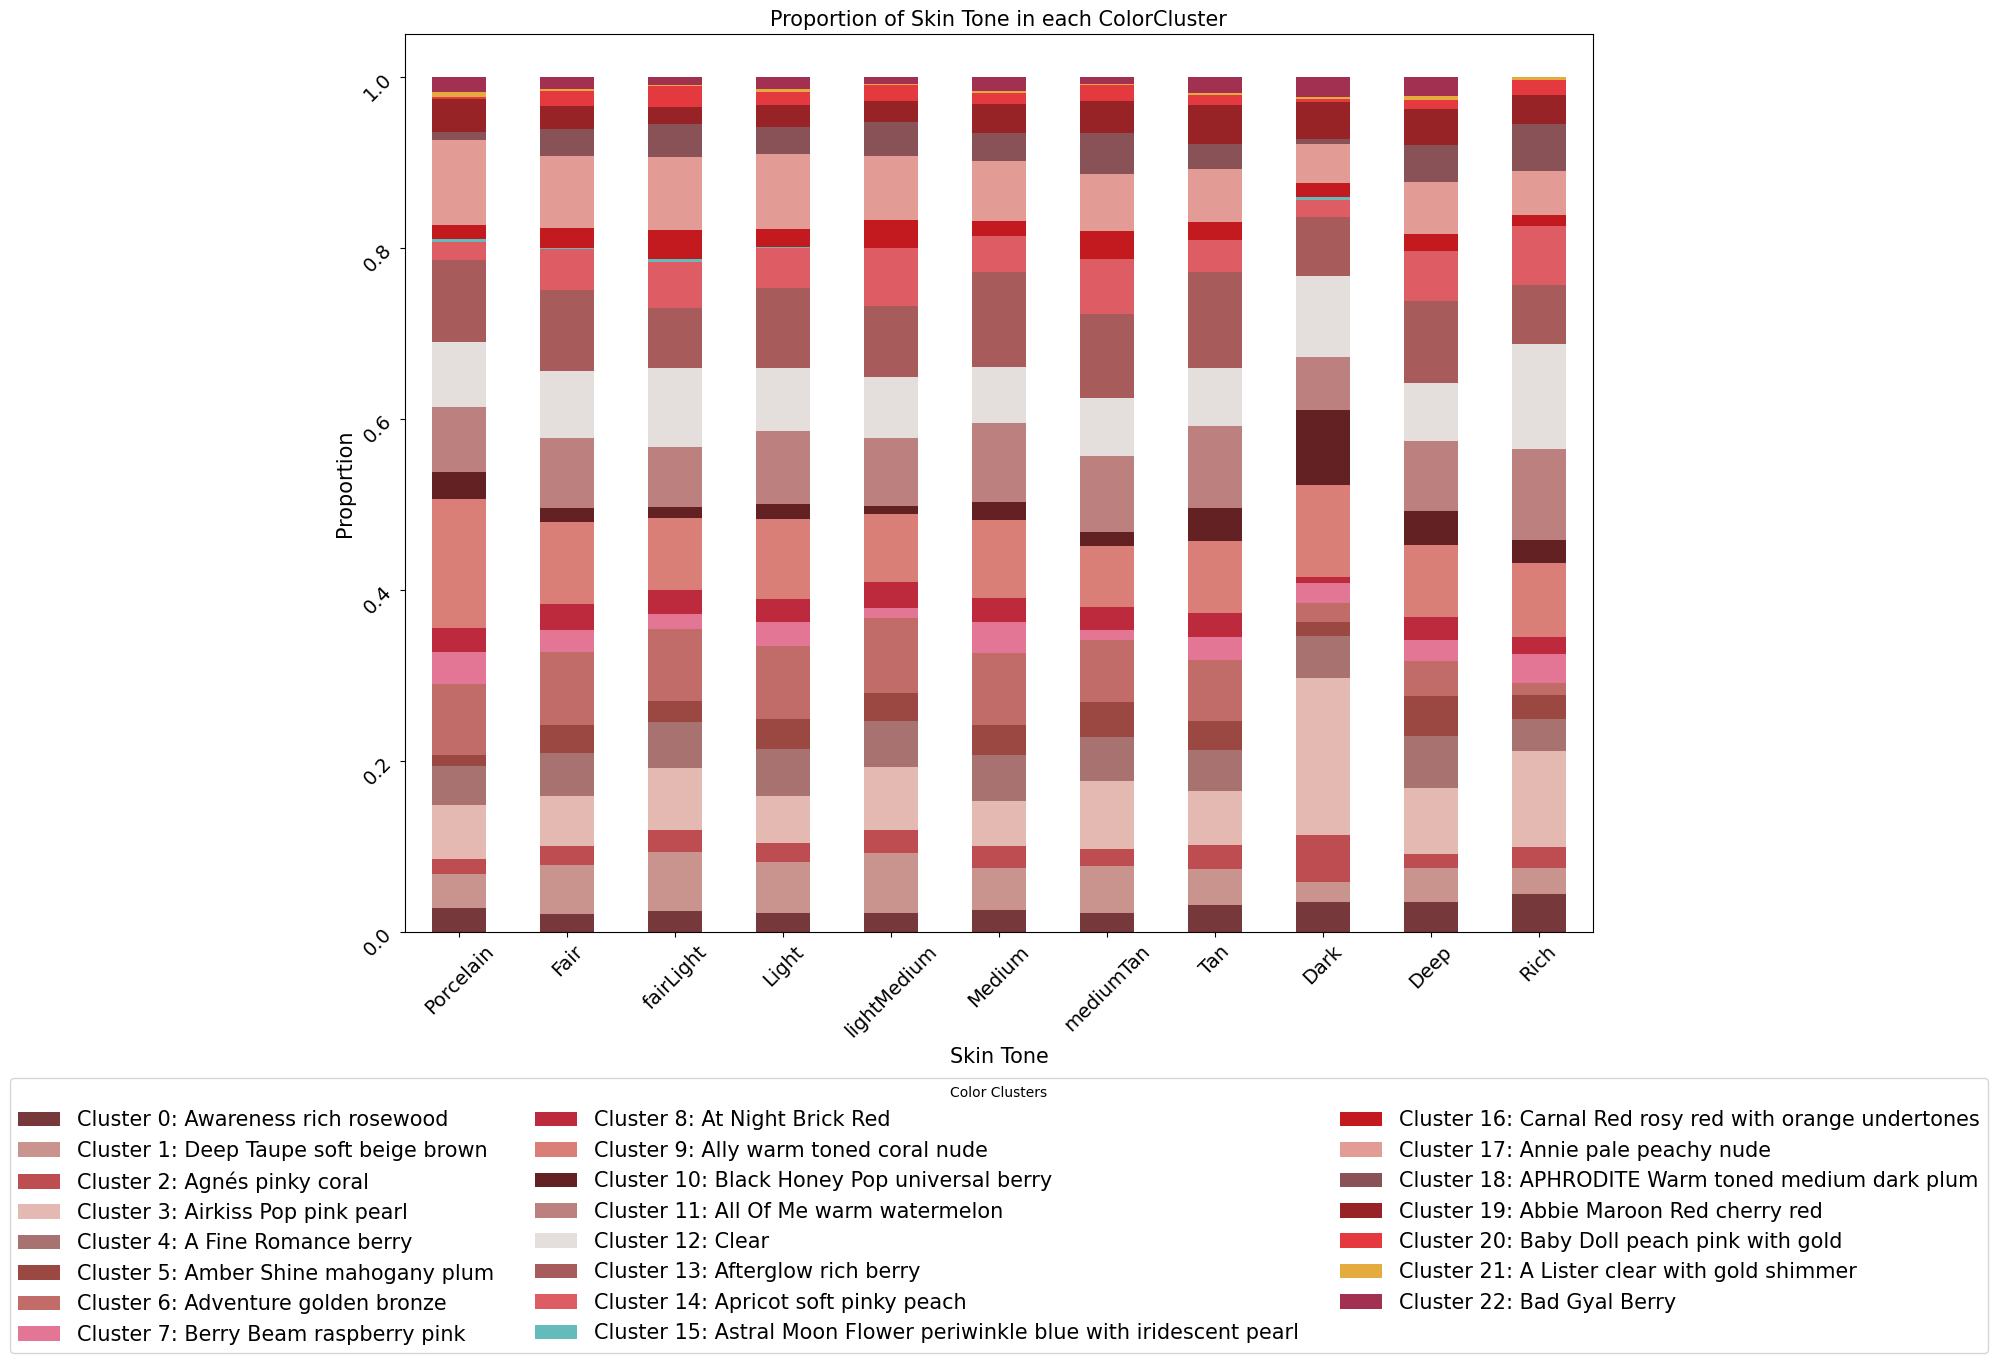

In [29]:
# Use this color map for your stacked bar chart
facetone_cluster_table = pd.crosstab(
    df_review['ContextDataValues.skinTone.ValueLabel'], 
    df_review['ColorCluster']
)

facetone_cluster_table = facetone_cluster_table.reindex(skin_tone_order)

facetone_cluster_table_norm = facetone_cluster_table.div(facetone_cluster_table.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(18, 14))
facetone_cluster_table_norm.plot(
    kind='bar', 
    stacked=True, 
    ax=ax,
    color=[color_map[i]['color'] for i in range(n_clusters)]
)

plt.title("Proportion of Skin Tone in each ColorCluster",fontsize = 15)
plt.xlabel("Skin Tone",fontsize = 15)
plt.ylabel("Proportion",fontsize = 15)

# Create legend with color names
legend_labels = [f"Cluster {i}: {color_map[i]['name']}" for i in range(n_clusters)]
plt.legend(
    title="Color Clusters", 
    labels=legend_labels,
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=3,
    fontsize = 15
)

plt.xticks(rotation=45, fontsize = 14)
plt.yticks(rotation=45, fontsize = 14)
plt.tight_layout()
plt.show()

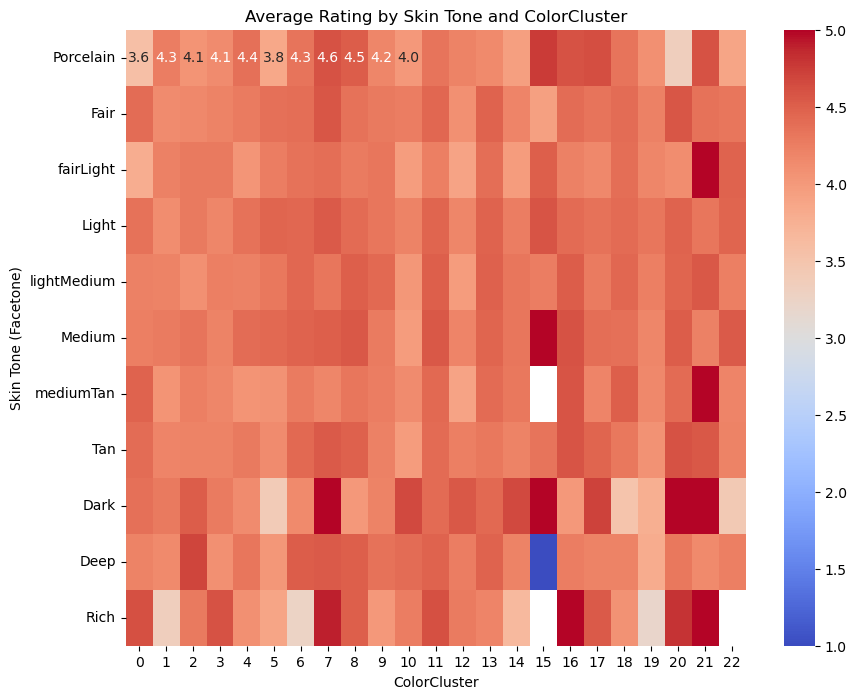

In [30]:
# Calculate the average rating by Skin Tone and ColorCluster and display in heatmap
facetone_cluster_avg_rating = df_review.pivot_table(
    values='Rating', 
    index='ContextDataValues.skinTone.ValueLabel', 
    columns='ColorCluster', 
    aggfunc='mean'
)

# Reorder the index based on `skin_tone_order`
facetone_cluster_avg_rating = facetone_cluster_avg_rating.reindex(skin_tone_order)

plt.figure(figsize=(10,8 ))
sns.heatmap(facetone_cluster_avg_rating, annot=True, cmap="coolwarm", fmt=".1f",annot_kws={"size": 10},
           robust=True,          
    vmin=facetone_cluster_avg_rating.min().min(),  # 
    vmax=facetone_cluster_avg_rating.max().max())   
plt.title("Average Rating by Skin Tone and ColorCluster")
plt.xlabel("ColorCluster")
plt.ylabel("Skin Tone (Facetone)")
plt.show()

# Recommendation Methods

### 1. Sephora Review-Based Recommendation  
- **Approach**: Select the best SKUs for each skin tone (11 skin tones).  
- **Criteria**:  
  - Average rating above 4.  
  - Top 20 products by review count.

### 2. Color-Based Recommendation  
- **Approach**: Select the best SKUs for each color cluster.  
- **Criteria**:  
  - Average rating above 4.  
  - Top 20 products by review count.  
  
### 3. Expert-Based Recommendation  
- **Approach**: Use recommended shades from the expert recommendation table to identify ideal lipstick products.  
- **Logic**: Calculate color similarity between lipstick RGB values and expert-recommended shades.


## Method 1: Sephora review-based Recommendation

### create top 20 sku per skin tone data frame

In [31]:
#select the best SKUs for each skin tone (11 skin tones), Best = an average rating above 4 and the top 20 by review count.

sku_summary = df_review.groupby(['ContextDataValues.skinTone.ValueLabel', 'skuID']).agg(
    skuRating=('Rating', 'mean'),                   # Calculate the average rating
    skuTotalReviews=('reviewID', 'count')              # Count total reviews per SKU
).reset_index()

filtered_skus = sku_summary[sku_summary['skuRating'] > 4]

df_sku_details = df_review.drop_duplicates(subset=['ContextDataValues.skinTone.ValueLabel', 'skuID'])
top_sku_data = filtered_skus.merge(df_sku_details, on=['ContextDataValues.skinTone.ValueLabel', 'skuID'], how='left')
top_sku_data = top_sku_data.sort_values(
    by=['ContextDataValues.skinTone.ValueLabel', 'skuTotalReviews'], 
    ascending=[True, False]
)

top_20_skus_per_skin_tone = top_sku_data.groupby('ContextDataValues.skinTone.ValueLabel').head(20)



In [32]:
top_20_skus_per_skin_tone = top_20_skus_per_skin_tone[['ContextDataValues.skinTone.ValueLabel', 'productID', 'skuID', 'brandName','displayName','currentSku.listPrice','currentSku.imageAltText',
        'color_description', 'URL',
         'skuRating', 'skuTotalReviews',
        'avg_rgb','cover_image_base64', 'lipstick_image_base64', 
        'ColorCluster', 'ClusterColorDescription'
]]


In [33]:
#add skin_id and rename ContextDataValues.skinTone.ValueLabel to Skin_Tone
# Step 1: Rename columns
top_20_skus_per_skin_tone = top_20_skus_per_skin_tone.rename(
    columns={
        'ContextDataValues.skinTone.ValueLabel': 'Skin_Tone_Name',
        'currentSku.listPrice': 'currentSku_listPrice', 'currentSku.imageAltText':'currentSku_imageAltText'
    }
)

# Step 2: Map Skin_ID_Sephora based on provided skin tone mapping
skin_tone_mapping = {
    'Fair': 1, 'fairLight': 2, 'Porcelain': 3, 'lightMedium': 4, 'Light': 5,
    'mediumTan': 6, 'Medium': 7, 'Tan': 8, 'Dark': 9, 'Deep': 10, 'Rich': 11
}

# Apply mapping to create 'Skin_ID_Sephora' column
top_20_skus_per_skin_tone['Skin_ID_Sephora'] = top_20_skus_per_skin_tone['Skin_Tone_Name'].map(skin_tone_mapping)

# Step 3: Reorder columns
column_order = [
    'Skin_ID_Sephora', 'Skin_Tone_Name', 
    'productID', 'skuID', 'brandName','displayName','currentSku_listPrice','currentSku_imageAltText',
     'color_description', 'URL',
     'skuRating', 'skuTotalReviews',
       'avg_rgb','cover_image_base64', 'lipstick_image_base64', 
       'ColorCluster', 'ClusterColorDescription'
]

top_20_skus_per_skin_tone = top_20_skus_per_skin_tone[column_order]


In [34]:
top_20_skus_per_skin_tone.to_excel('skinToneRecommendation_top_20_skus_per_skinTone.xlsx', index=False)
top_20_skus_per_skin_tone.head(2)

,Skin_ID_Sephora,Skin_Tone_Name,productID,skuID,brandName,displayName,currentSku_listPrice,currentSku_imageAltText,color_description,URL,skuRating,skuTotalReviews,avg_rgb,cover_image_base64,lipstick_image_base64,ColorCluster,ClusterColorDescription
38,9,Dark,P444149,2225928,Fenty Beauty by Rihanna,Pro Kiss'r Luscious Lip Balm,$20.00,Fenty Beauty by Rihanna - Pro Kiss'r Luscious ...,Hint Hint universal invisipink sheen,https://www.sephora.com/product/pro-kiss-r-lus...,4.294118,51,"[237, 184, 174]",/9j/4AAQSkZJRgABAQIAdgB2AAD/2wCEAAUFBQUFBQYGBg...,/9j/4QQvRXhpZgAASUkqAAgAAAAMAAABAwABAAAAJAAAAA...,3,Airkiss Pop pink pearl
59,9,Dark,P42204,683490,Rosebud Perfume Co.,Rosebud Salve,$7.00,Rosebud Perfume Co. - Rosebud Salve,Out of stock: Rosebud Salve,https://www.sephora.com/product/rosebud-salve-...,4.473684,19,"[236, 215, 220]",/9j/4AAQSkZJRgABAQIAdgB2AAD/2wCEAAMDAwMDAwQEBA...,/9j/4AAQSkZJRgABAgAAZABkAAD/7AARRHVja3kAAQAEAA...,12,Clear


### to display one SKU image, cover image and URL

In [35]:
def display_sku_and_cover_images_url(skuID, df):
    """
    Display SKU information, lipstick image, and cover image if available
    
    Parameters:
    skuID: ID of the SKU to display
    df: DataFrame containing the SKU data
    """
    # Check if the dataframe contains the specified skuID
    if skuID not in df['skuID'].values:
        print(f"SKU ID {skuID} not found in the DataFrame.")
        return
    
    
    url = df.loc[df['skuID'] == skuID, 'URL'].values[0]
    display(HTML(f"<a href='{url}' target='_blank'>Click here to view product page</a>"))

   
    sku_image_base64 = df.loc[df['skuID'] == skuID, 'lipstick_image_base64'].values[0]
    sku_img_data = base64.b64decode(sku_image_base64)
    sku_img = Image.open(BytesIO(sku_img_data))
    print("Displaying SKU Image:")
    display(sku_img)
    
    # Retrieve and decode the cover image if available, some sku does not have cover image
    try:
        cover_image_base64 = df.loc[df['skuID'] == skuID, 'cover_image_base64'].values[0]
        if pd.notna(cover_image_base64) and cover_image_base64:  # Check if value exists and is not empty
            cover_img_data = base64.b64decode(cover_image_base64)
            cover_img = Image.open(BytesIO(cover_img_data))
            print("Displaying Cover Image:")
            display(cover_img)
        else:
            print("Cover image is not available.")
    except (UnidentifiedImageError, ValueError, binascii.Error) as e:
        print(f"Could not display cover image: {str(e)}")

In [36]:
sku = '2225928'

Displaying SKU Image:


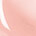

Displaying Cover Image:


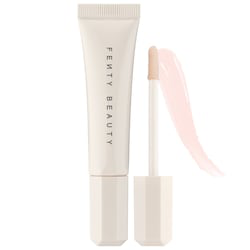

In [37]:
display_sku_and_cover_images_url(sku, top_20_skus_per_skin_tone)

## Method 2: Color-based Recommendation


In [38]:
#select the best SKUs for color cluster (k= 23), Best = an average rating above 4 and the top 20 by review count.

filtered_skus = df_sku[df_sku['skuRating'] > 4]

top_sku_colorCluster = filtered_skus.sort_values(
    by=['ColorCluster', 'skuTotalReviews'], 
    ascending=[True, False]
)

top_20_skus_per_colorCluster = top_sku_colorCluster.groupby('ColorCluster').head(20)
top_20_skus_per_colorCluster = top_20_skus_per_colorCluster[
    ['productID', 'skuID','brandName','displayName','currentSku_listPrice','currentSku_imageAltText',
     'color_description', 'URL',
     'skuRating', 'skuTotalReviews',
        'avg_rgb','cover_image_base64', 'lipstick_image_base64', 
       'ColorCluster', 'ClusterColorDescription',   
     'cluster_R','cluster_G','cluster_B'
    ]
]


In [39]:
top_20_skus_per_colorCluster.head(2)

,productID,skuID,brandName,displayName,currentSku_listPrice,currentSku_imageAltText,color_description,URL,skuRating,skuTotalReviews,avg_rgb,cover_image_base64,lipstick_image_base64,ColorCluster,ClusterColorDescription,cluster_R,cluster_G,cluster_B
413,P457245,2510097,Givenchy,Rose Perfecto Hydrating Tinted Lip Balm & Gloss,$39.00,Givenchy - Rose Perfecto Hydrating Tinted Lip ...,011 Black Pink blackend pink that transforms t...,https://www.sephora.com/product/givenchy-le-ro...,4.306723,238,"[103, 68, 79]",,/9j/4QPARXhpZgAATU0AKgAAAAgADAEAAAMAAAABB9AAAA...,0,Awareness rich rosewood,0.465686,0.220136,0.232805
201,P455324,2302537,bareMinerals,Mineralist Hydra-Smoothing Lipstick,$22.00,bareMinerals - Mineralist Hydra-Smoothing Lips...,Awareness rich rosewood,https://www.sephora.com/product/bareminerals-m...,4.420290,138,"[128, 44, 45]",,/9j/4QP6RXhpZgAASUkqAAgAAAAMAAABAwABAAAAJAAAAA...,0,Awareness rich rosewood,0.465686,0.220136,0.232805


In [40]:
top_20_skus_per_colorCluster.to_excel('colorClusterRecommendation_top_20_skus_per_colorCluster.xlsx', index=False)

In [41]:
#create a color cluster table: color cluster, color cluster name, RGB (0-255 scale), and SKU count. 

cluster_summary = top_20_skus_per_colorCluster[['ColorCluster', 'ClusterColorDescription', 
                                               'cluster_R', 'cluster_G', 'cluster_B']].drop_duplicates()

sku_counts = df_sku['ColorCluster'].value_counts().reset_index()
sku_counts.columns = ['ColorCluster', 'SKU_Count']
cluster_summary = cluster_summary.merge(sku_counts, on='ColorCluster')
cluster_summary = cluster_summary.sort_values('ColorCluster')
cluster_summary['cluster_R'] = (cluster_summary['cluster_R'] * 255).round().astype(int)
cluster_summary['cluster_G'] = (cluster_summary['cluster_G'] * 255).round().astype(int)
cluster_summary['cluster_B'] = (cluster_summary['cluster_B'] * 255).round().astype(int)



In [42]:
color_cluster_table = cluster_summary[['ColorCluster', 'ClusterColorDescription', 'cluster_R','cluster_G','cluster_B','SKU_Count']]

In [43]:
color_cluster_table.to_excel('colorClusterRecommendation_color_cluster_table.xlsx', index=False)

In [44]:
sku = '2307122'

In [45]:
top_20_skus_per_colorCluster.loc[top_20_skus_per_colorCluster['skuID']== sku]

,productID,skuID,brandName,displayName,currentSku_listPrice,currentSku_imageAltText,color_description,URL,skuRating,skuTotalReviews,avg_rgb,cover_image_base64,lipstick_image_base64,ColorCluster,ClusterColorDescription,cluster_R,cluster_G,cluster_B
216,P501504,2307122,Laura Mercier,Petal Soft Lipstick Crayon,$35.00,Laura Mercier - Petal Soft Lipstick Crayon,343 Noémie mid tone plum,https://www.sephora.com/product/petal-soft-lip...,4.666667,3,"[150, 63, 86]",,/9j/4QAYRXhpZgAASUkqAAgAAAAAAAAAAAAAAP/sABFEdW...,22,Bad Gyal Berry,0.636166,0.195425,0.317865


Displaying SKU Image:


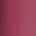

Cover image is not available.


In [46]:
display_sku_and_cover_images_url(sku, top_20_skus_per_colorCluster)

## Method 3: Expert-based Recommendation

In [47]:
#load expert table
file_path = "data/expertRecommendation_skinTone_RGB.xlsx"
df_expert = pd.read_excel(file_path)

In [48]:
def find_similar_colors_for_all(skin_df, df_sku, top_n=10):
    """
    Find top n similar colors in df_sku for each color in skin tone table
    
    Parameters:
    skin_df: DataFrame containing skin tone colors (with R,G,B in 0-255 scale)
    df_sku: DataFrame containing lipstick colors (with R,G,B in 0-1 scale)
    top_n: number of similar colors to find for each skin tone color
    """
    all_matches = []
    
    for _, skin_row in skin_df.iterrows():
        skin_rgb = np.array([skin_row['R'], skin_row['G'], skin_row['B']]) / 255.0
        
        sku_colors = df_sku[['R', 'G', 'B']].values
        
        distances = euclidean_distances([skin_rgb], sku_colors)[0]
        
        similar_indices = np.argsort(distances)[:top_n]
        
        for idx in similar_indices:
            match_info = {
                'Skin_ID': skin_row['Skin ID'],
                'Skin_Tone': skin_row['Skin Tone'],
                'Skin_Undertone': skin_row['Color'],
                'Color_ID': skin_row['Color ID'],
                'Skin_R': skin_row['R'],
                'Skin_G': skin_row['G'],
                'Skin_B': skin_row['B'],
                'Skin_Hex': skin_row['Hex'],
                'skuID': df_sku.iloc[idx]['skuID'],
                'productID': df_sku.iloc[idx]['productID'],
                'brandName': df_sku.iloc[idx]['brandName'],
                'displayName': df_sku.iloc[idx]['displayName'],
                'color_description': df_sku.iloc[idx]['color_description'],
                'ColorCluster': df_sku.iloc[idx]['ColorCluster'],
                'ClusterColorDescription': df_sku.iloc[idx]['ClusterColorDescription'],
                
                'R': df_sku.iloc[idx]['R'] * 255,  
                'G': df_sku.iloc[idx]['G'] * 255,
                'B': df_sku.iloc[idx]['B'] * 255,
                'Color_Distance': distances[idx],
                'skuRating': df_sku.iloc[idx]['skuRating'],
                'skuTotalReviews': df_sku.iloc[idx]['skuTotalReviews'],
                'currentSku_listPrice': df_sku.iloc[idx]['currentSku_listPrice'],
                'URL': df_sku.iloc[idx]['URL'],
                'cover_image_base64': df_sku.iloc[idx]['cover_image_base64'],
                'lipstick_image_base64': df_sku.iloc[idx]['lipstick_image_base64'],
                'currentSku_imageAltText':df_sku.iloc[idx]['currentSku_imageAltText'],
                'avg_rgb':df_sku.iloc[idx]['avg_rgb']
                
            }
            all_matches.append(match_info)
    

    matches_df = pd.DataFrame(all_matches)
    matches_df = matches_df.sort_values(['Color_ID', 'Color_Distance'])
    
    return matches_df


In [49]:
results = find_similar_colors_for_all(df_expert, df_sku, top_n=10)

In [50]:
results.head(2)

,Skin_ID,Skin_Tone,Skin_Undertone,Color_ID,Skin_R,Skin_G,Skin_B,Skin_Hex,skuID,productID,brandName,displayName,color_description,ColorCluster,ClusterColorDescription,R,G,B,Color_Distance,skuRating,skuTotalReviews,currentSku_listPrice,URL,cover_image_base64,lipstick_image_base64,currentSku_imageAltText,avg_rgb
0,1,FAIR,WARM,1,241,133,121,#F18579,2514909,P479337,NARS,Afterglow Lip Shine Gloss,Orgasm peachy pink with golden shimmer,9,Ally warm toned coral nude,238.0,125.0,125.0,0.036996,4.664234,137,$28.00,https://www.sephora.com/product/nars-afterglow...,/9j/4AAQSkZJRgABAQIAdgB2AAD/2wCEAAkJCQkKCQoMDA...,/9j/4QRTRXhpZgAASUkqAAgAAAAQAAABAwABAAAAwwMAAA...,NARS - Afterglow Lip Shine Gloss,"[238, 125, 125]"
1,1,FAIR,WARM,1,241,133,121,#F18579,2551562,P109906,Laura Mercier,Lip Glacé Lip Gloss,125 Rosé pale pink,9,Ally warm toned coral nude,231.0,139.0,121.0,0.045733,4.500000,4,$32.00,https://www.sephora.com/product/lip-glace-P109...,,/9j/4QRTRXhpZgAASUkqAAgAAAAQAAABAwABAAAAwwMAAA...,Laura Mercier - Lip Glacé Lip Gloss,"[231, 139, 121]"


In [51]:
results['Skin_Name'] = results['Skin_Tone'] + '_'+results['Skin_Undertone']

In [52]:
column_order = ['Skin_ID', 'Skin_Tone', 'Skin_Undertone','Skin_Name',
    'Color_ID', 'Skin_R', 'Skin_G', 'Skin_B', 'Skin_Hex', 
    'productID', 'skuID', 'brandName','displayName','currentSku_listPrice','currentSku_imageAltText',
     'color_description', 'URL',
     'skuRating', 'skuTotalReviews',
       'avg_rgb','cover_image_base64', 'lipstick_image_base64', 
       'ColorCluster', 'ClusterColorDescription',
        
]
results = results[column_order]

In [53]:
results.to_excel('expertRecommendation_top_10_skus_per_RBG.xlsx', index=False)

In [54]:
sku = '2514909'

In [55]:
results.loc[results['skuID']== sku]

,Skin_ID,Skin_Tone,Skin_Undertone,Skin_Name,Color_ID,Skin_R,Skin_G,Skin_B,Skin_Hex,productID,skuID,brandName,displayName,currentSku_listPrice,currentSku_imageAltText,color_description,URL,skuRating,skuTotalReviews,avg_rgb,cover_image_base64,lipstick_image_base64,ColorCluster,ClusterColorDescription
0,1,FAIR,WARM,FAIR_WARM,1,241,133,121,#F18579,P479337,2514909,NARS,Afterglow Lip Shine Gloss,$28.00,NARS - Afterglow Lip Shine Gloss,Orgasm peachy pink with golden shimmer,https://www.sephora.com/product/nars-afterglow...,4.664234,137,"[238, 125, 125]",/9j/4AAQSkZJRgABAQIAdgB2AAD/2wCEAAkJCQkKCQoMDA...,/9j/4QRTRXhpZgAASUkqAAgAAAAQAAABAwABAAAAwwMAAA...,9,Ally warm toned coral nude


Displaying SKU Image:


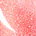

Displaying Cover Image:


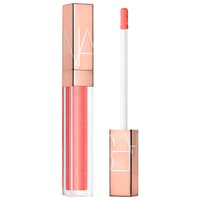

In [56]:
display_sku_and_cover_images_url(sku, top_20_skus_per_colorCluster)